In [12]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
from pathlib import Path
import matplotlib.pyplot as plt
import anndata
import sys
sys.path.append('/home/lytq/Spatial-Transcriptomics-Benchmark/utils')
from sdmbench import compute_ARI, compute_NMI, compute_CHAOS, compute_PAS, compute_ASW, compute_HOM, compute_COM

import time
import psutil
import tracemalloc

from SpaceFlow import SpaceFlow

def evaluate_clustering(adata: sc.AnnData, df_meta, time_taken: float, memory_used: float, output_dir: str) -> dict:
    """Evaluate clustering using sdmbench"""
    gt_key = 'ground_truth'
    pred_key = 'pred'
    adata.obs['ground_truth'] = df_meta['fine_annot_type'].values
    adata = adata[~pd.isnull(adata.obs['ground_truth'])]
    
    results = {
        "ARI": compute_ARI(adata, gt_key, pred_key),
        "AMI": compute_NMI(adata, gt_key, pred_key),
        "Homogeneity": compute_HOM(adata, gt_key, pred_key),
        "Completeness": compute_COM(adata, gt_key, pred_key),
        "ASW": compute_ASW(adata, pred_key),
        "CHAOS": compute_CHAOS(adata, pred_key),
        "PAS": compute_PAS(adata, pred_key),
        "Time": time_taken,
        "Memory": memory_used
    }
    
    df_results = pd.DataFrame([results])
    df_results.to_csv(os.path.join(output_dir, "metrics.csv"), index=False)
    return results

BASE_PATH = Path('/home/lytq/Spatial-Transcriptomics-Benchmark/data/BRCA1')
output_path = Path('/home/lytq/Spatial-Transcriptomics-Benchmark/results2/BRCA1/SpaceFlow')

sample = 'V1_Human_Breast_Cancer_Block_A_Section_1'

In [13]:
dir_input = Path(f'{BASE_PATH}/{sample}/')
dir_output = Path(f'{output_path}/')
dir_output.mkdir(parents=True, exist_ok=True)

n_clusters = 20

start_time = time.time()
tracemalloc.start()

adata = sc.read_visium(dir_input)
adata.var_names_make_unique()
gt_df = pd.read_csv(dir_input / 'metadata.tsv', sep='\t')
adata.obs['layer_guess'] = gt_df['fine_annot_type'].values

sc.pp.filter_genes(adata, min_cells=3)

sf = SpaceFlow.SpaceFlow(adata=adata)
sf.preprocessing_data(n_top_genes=3000)

sf.train(
    spatial_regularization_strength=0.1,
    z_dim=50,
    lr=1e-3,
    epochs=1000,
    max_patience=50,
    min_stop=100,
    random_seed=42,
    gpu=1,
    regularization_acceleration=True,
    edge_subset_sz=1000000,
    embedding_save_filepath=os.path.join(dir_output, "low_dim_data.csv"),
)

/home/lytq/.conda/envs/spaceflow_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/lytq/.conda/envs/spaceflow_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Epoch 2/1000, Loss: 1.6079705953598022
Epoch 12/1000, Loss: 1.3916908502578735
Epoch 22/1000, Loss: 1.1771299839019775
Epoch 32/1000, Loss: 0.8185995221138
Epoch 42/1000, Loss: 0.5339844226837158
Epoch 52/1000, Loss: 0.3812273442745209
Epoch 62/1000, Loss: 0.27695155143737793
Epoch 72/1000, Loss: 0.19584350287914276
Epoch 82/1000, Loss: 0.15436093509197235
Epoch 92/1000, Loss: 0.13435545563697815
Epoch 102/1000, Loss: 0.10494053363800049
Epoch 112/1000, Loss: 0.0935283675789833
Epoch 122/1000, Loss: 0.08721430599689484
Epoch 132/1000, Loss: 0.07466031610965729
Epoch 142/1000, Loss: 0.06714258342981339
Epoch 152/1000, Loss: 0.06780184805393219
Epoch 162/1000, Loss: 0.06086186692118645
Epoch 172/1000, Loss: 0.06646484136581421
Epoch 182/1000, Loss: 0.05643750727176666
Epoch 192/1000, Loss: 0.05311659350991249
Epoch 202/1000, Loss: 0.04994736984372139
Epoch 212/1000, Loss: 0.05105387419462204
Epoch 222/1000, Loss: 0.05185095593333244
Epoch 232/1000, Loss: 0.04887191206216812
Epoch 242/100

array([[-0.25261015, -0.44951546,  1.1129942 , ...,  1.816218  ,
         1.3042741 ,  0.08854038],
       [-0.18938145,  0.19128577,  2.2944891 , ...,  0.67179245,
        -0.1940774 ,  0.7598162 ],
       [-0.48338798, -0.53121346, -0.16708441, ...,  1.5302212 ,
        -0.18495904, -0.05870083],
       ...,
       [-0.17712924, -0.01405266,  2.3145726 , ...,  0.52240354,
        -0.19372673,  0.46302634],
       [ 1.6001579 , -0.24627514, -0.0515664 , ...,  2.362111  ,
        -0.01651776,  1.5345178 ],
       [ 3.1556683 , -0.38617525, -0.11908546, ...,  0.5631124 ,
         0.49086338, -0.01622464]], dtype=float32)

In [14]:
adata.obsm['SpaceFlow'] = sf.embedding

In [15]:
adata.obsm['SpaceFlow']

array([[-0.25261015, -0.44951546,  1.1129942 , ...,  1.816218  ,
         1.3042741 ,  0.08854038],
       [-0.18938145,  0.19128577,  2.2944891 , ...,  0.67179245,
        -0.1940774 ,  0.7598162 ],
       [-0.48338798, -0.53121346, -0.16708441, ...,  1.5302212 ,
        -0.18495904, -0.05870083],
       ...,
       [-0.17712924, -0.01405266,  2.3145726 , ...,  0.52240354,
        -0.19372673,  0.46302634],
       [ 1.6001579 , -0.24627514, -0.0515664 , ...,  2.362111  ,
        -0.01651776,  1.5345178 ],
       [ 3.1556683 , -0.38617525, -0.11908546, ...,  0.5631124 ,
         0.49086338, -0.01622464]], dtype=float32)

In [16]:
embedding = anndata.AnnData(sf.embedding)
sc.pp.neighbors(embedding, n_neighbors=50, use_rep='X')

for res in sorted(list(np.arange(0.2, 2.5, 0.1)), reverse=True):
    sc.tl.leiden(embedding, resolution=res)
    
    if len(pd.DataFrame(embedding.obs['leiden']).leiden.unique()) == n_clusters:
        print(f"Resolution: {res}")
        break

sf.segmentation(domain_label_save_filepath=os.path.join(dir_output, "domain_labels.csv"),
                n_neighbors=50,
                resolution=res)

sc.pp.neighbors(adata, n_neighbors=50)
sc.tl.umap(adata)

pred = pd.read_csv(os.path.join(dir_output, "domain_labels.csv"), header=None)
adata.obs['pred'] = pred.values
adata.obs["pred"] = adata.obs["pred"].astype("category")  # Convert to categorical

end_time = time.time()
time_taken = end_time - start_time
current, peak = tracemalloc.get_traced_memory()
memory_used = peak / (1024 ** 2)
tracemalloc.stop()

metrics = evaluate_clustering(adata, gt_df, time_taken, memory_used, dir_output)

Resolution: 1.7000000000000004
Performing domain segmentation
Segmentation complete, domain labels of cells or spots saved at /home/lytq/Spatial-Transcriptomics-Benchmark/results2/BRCA1/SpaceFlow/domain_labels.csv !


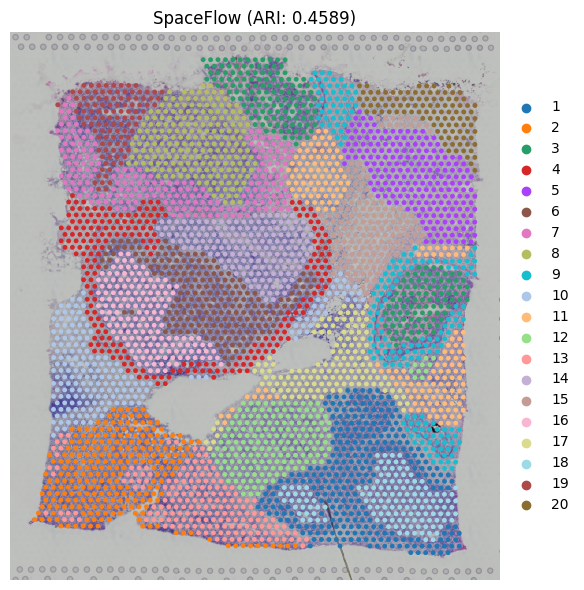

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.spatial(adata, color='pred', ax=axes, show=False)
axes.set_title(f'SpaceFlow (ARI: {metrics["ARI"]:.4f})')
handles, labels = axes.get_legend_handles_labels()
new_labels = [str(int(label) + 1) if label.isdigit() else label for label in labels]
axes.legend(handles, new_labels, loc='center left', frameon=False, bbox_to_anchor=(1, 0.5))
axes.axis('off')
plt.tight_layout()
plt.savefig(dir_output / 'clustering.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
adata.obs['pred'].values

[10, 1, 4, 9, 1, ..., 13, 1, 1, 3, 7]
Length: 3798
Categories (20, int64): [0, 1, 2, 3, ..., 16, 17, 18, 19]

In [21]:
adata.obs['pred_shift'] = (adata.obs['pred'].astype(int) + 1).astype("category")

/home/lytq/.conda/envs/spaceflow_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/lytq/.conda/envs/spaceflow_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


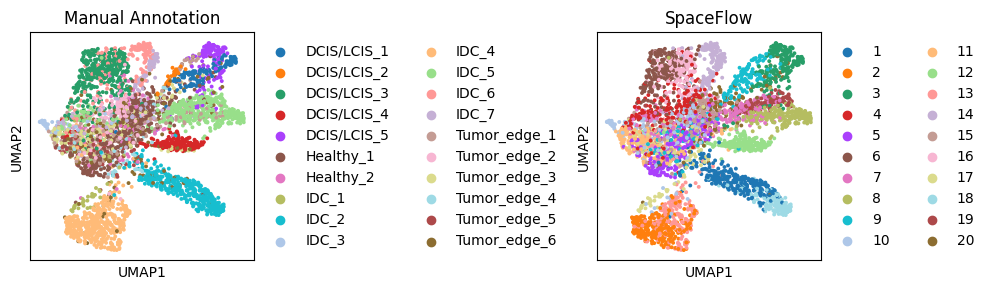

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
sc.pl.umap(adata, color='ground_truth', ax=ax[0], show=False)
sc.pl.umap(adata, color='pred_shift', ax=ax[1], show=False)
ax[0].set_title('Manual Annotation')
ax[1].set_title('SpaceFlow')
# handles, labels = ax[1].get_legend_handles_labels()
# new_labels = [str(int(label) + 1) if label.isdigit() else label for label in labels]
# ax[1].legend(handles, new_labels, loc='center left', frameon=False, bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(dir_output / 'umap.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
adata.obs

,in_tissue,array_row,array_col,layer_guess,pred,ground_truth
AAACAAGTATCTCCCA-1,1,50,102,NaN,10,Tumor_edge_5
AAACACCAATAACTGC-1,1,59,19,NaN,1,IDC_4
AAACAGAGCGACTCCT-1,1,14,94,NaN,4,Healthy_1
AAACAGGGTCTATATT-1,1,47,13,NaN,11,IDC_3
AAACAGTGTTCCTGGG-1,1,73,43,NaN,1,IDC_4
...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77,NaN,7,IDC_7
TTGTTTCACATCCAGG-1,1,58,42,NaN,1,IDC_4
TTGTTTCATTAGTCTA-1,1,60,30,NaN,1,IDC_4
TTGTTTCCATACAACT-1,1,45,27,NaN,18,Tumor_edge_2


In [25]:
low_dim_data = pd.DataFrame(adata.obsm["SpaceFlow"], index=adata.obs.index)
low_dim_data.to_csv(dir_output / 'low_dim_data.csv', index=False)

adata.obs.to_csv(dir_output / 'cell_metadata.csv', index=False)
umap_coords = adata.obsm["X_umap"]
spot_ids = adata.obs_names
umap_df = pd.DataFrame(umap_coords, columns=["UMAP1", "UMAP2"])
umap_df["spot_id"] = spot_ids
umap_df = umap_df[["spot_id", "UMAP1", "UMAP2"]]
umap_df.to_csv(dir_output / "spatial_umap_coords.csv", index=False)